In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import random

In [2]:
class MURABinaryDataset(Dataset):
    """
    Carga imágenes de MURA, asignando etiquetas binarias:
    0 = negative, 1 = positive
    """
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".png") and "._" not in file:
                    full_path = os.path.join(root, file)
                    label = 1 if "positive" in root.lower() else 0
                    self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
#Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
#Carga de datos
DATA_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"

train_dataset = MURABinaryDataset(os.path.join(DATA_DIR, "train"), transform=transform)
valid_dataset = MURABinaryDataset(os.path.join(DATA_DIR, "valid"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

print(f"Train imgs: {len(train_dataset)} | Valid imgs: {len(valid_dataset)}")

Train imgs: 36808 | Valid imgs: 3197


In [ ]:


EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 3

In [ ]:
#Modelo ResNet18
resnet = resnet18(weights="DEFAULT")
resnet.fc = nn.Linear(resnet.fc.in_features, 2)  # Clasificación binaria
resnet = resnet.to(DEVICE)

In [9]:
#Entrenamiento + Validación + early stopping
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validación
    resnet.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(resnet.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_fulldata.pt")
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping activado.")
            break

Epoch 1 | Train Loss: 0.5038 | Val Loss: 0.4607 | Acc: 0.7926 | F1: 0.7702
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.4203 | Val Loss: 0.4664 | Acc: 0.7917 | F1: 0.7700
Epoch 3 | Train Loss: 0.3551 | Val Loss: 0.5626 | Acc: 0.7698 | F1: 0.7182
Epoch 4 | Train Loss: 0.2711 | Val Loss: 0.6031 | Acc: 0.7810 | F1: 0.7402
Early stopping activado.



 Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       0.74      0.90      0.81      1667
    positive       0.86      0.65      0.74      1530

    accuracy                           0.78      3197
   macro avg       0.80      0.78      0.78      3197
weighted avg       0.79      0.78      0.78      3197



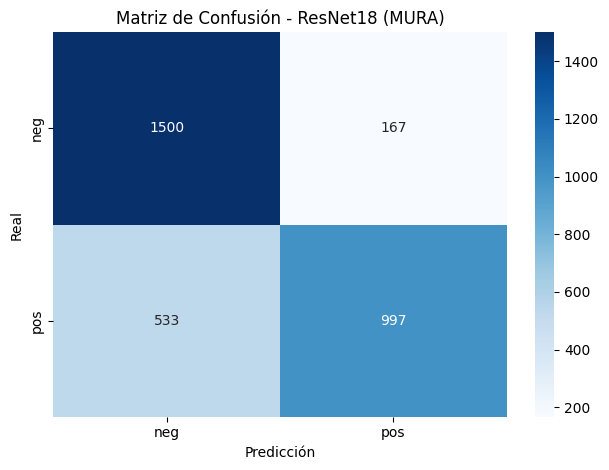

In [10]:
print("\n Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.title("Matriz de Confusión - ResNet18 (MURA)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.193377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.35677567].


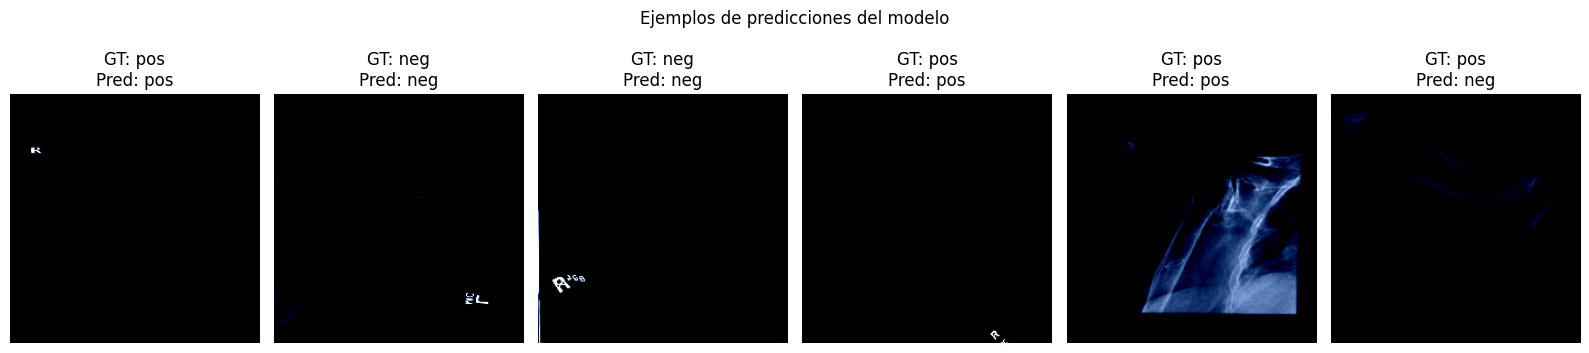

In [11]:
# Mostrar 6 imágenes al azar con su predicción real/predicha
def visualize_predictions(model, dataset, num_images=6):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(16, 4))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        axes[i].axis('off')
        axes[i].set_title(f"GT: {'pos' if label else 'neg'}\nPred: {'pos' if pred.item() else 'neg'}")
    plt.suptitle("Ejemplos de predicciones del modelo")
    plt.tight_layout()
    plt.show()

# Llamar a la función
visualize_predictions(resnet, valid_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.193377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3986644..1.2979523].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.8556864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-0.8981263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.

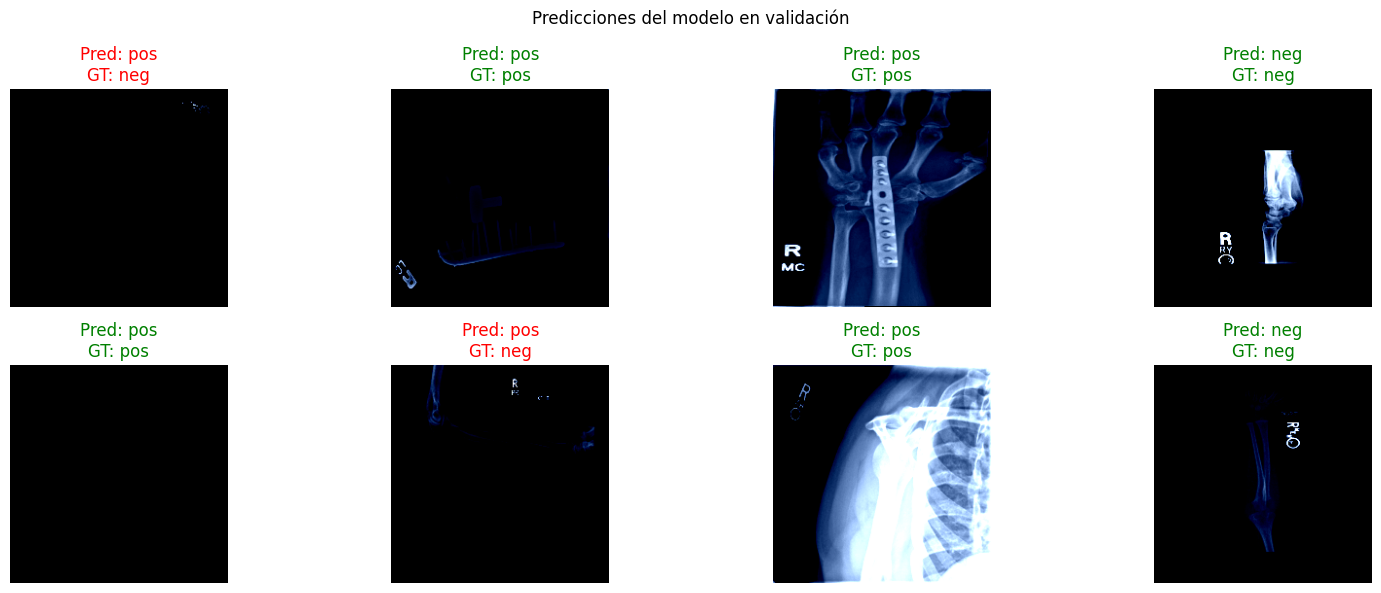

In [12]:
import torch
import matplotlib.pyplot as plt
import random

# 🔁 Asegúrate de tener esta ruta y el modelo cargado:
resnet.load_state_dict(torch.load("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_fulldata.pt", map_location=DEVICE))
resnet.eval()

#Función de visualización
def show_predictions(model, dataset, n_samples=8):
    indices = random.sample(range(len(dataset)), n_samples)
    fig, axes = plt.subplots(2, n_samples // 2, figsize=(16, 6))

    for ax, idx in zip(axes.flatten(), indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
        
        pred_label = pred.item()
        real_label = label

        # Formato visual
        img_disp = image.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img_disp)
        ax.axis("off")
        
        color = "green" if pred_label == real_label else "red"
        ax.set_title(f"Pred: {'pos' if pred_label else 'neg'}\nGT: {'pos' if real_label else 'neg'}", color=color)

    plt.suptitle("Predicciones del modelo en validación")
    plt.tight_layout()
    plt.show()

#Llamada a la función con el dataset de validación
show_predictions(resnet, valid_dataset)
